In [64]:
#!pip install pyspark
#!pip install matplotlib

In [65]:
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, IntegerType, DateType
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from builtins import max as MAX
import random

In [66]:
spark = SparkSession.builder.appName("Project").getOrCreate()

In [67]:
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

df = spark.read.option("header", "false") \
               .option("inferSchema", "true") \
               .option("quote", '"') \
               .option("escape", '"') \
               .option("multiLine", "true") \
               .csv("dataSet140.csv")


df = df.toDF(*column_names)


In [84]:
df.show()

+------+----------+-----------+--------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|target|       ids|       date|    flag|           user|                text|           textSplit|               words|      filtered_words|        cleaned_text|
+------+----------+-----------+--------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|1467810369|06-Apr-2009|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|[@switchfoot, htt...|[@switchfoot, htt...|[@switchfoot, htt...|@switchfoot http:...|
|     0|1467810672|06-Apr-2009|NO_QUERY|  scotthamilton|is upset that he ...|[is, upset, that,...|[is, upset, that,...|[upset, can't, up...|upset can't updat...|
|     0|1467810917|06-Apr-2009|NO_QUERY|       mattycus|@Kenichan I dived...|[@Kenichan, I, di...|[@Kenichan, I, di...|[@Kenichan, I, di...|@Kenichan I dived...|
|     0|1467811184|06-Apr-20

In [69]:
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- ids: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [70]:
df = df.withColumn("dateSplit", split(col("date"), " "))
df = df.withColumn("date", concat(col("dateSplit").getItem(2), lit("-") , col("dateSplit").getItem(1),lit("-") ,col("dateSplit").getItem(5)))
df = df.drop("dateSplit")

In [71]:
df = df.na.drop(how = 'any')

In [72]:
print(f"There are {df.filter(col('target') == 0).count()} negative tweets and {df.filter(col('target') == 4).count()} positive")

There are 800000 negative tweets and 800000 positive


In [73]:
def missing_values(df):
    missing_values_conditions = [
        count(when(isnan(c) | col(c).isNull(), c)).alias(c) if df.schema[c].dataType in ['DoubleType', 'FloatType'] else count(when(col(c).isNull(), c)).alias(c)
        for c in df.columns
    ]
    df.select(missing_values_conditions).show()

In [74]:
missing_values(df)

+------+---+----+----+----+----+
|target|ids|date|flag|user|text|
+------+---+----+----+----+----+
|     0|  0|   0|   0|   0|   0|
+------+---+----+----+----+----+



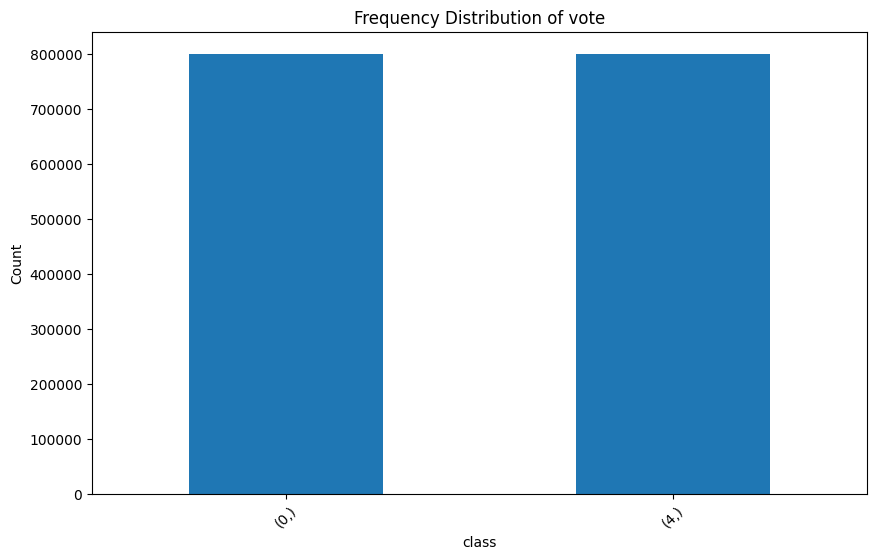

In [78]:
dfTemp = df.select("target").toPandas()
plt.figure(figsize=(10, 6))
dfTemp.value_counts().plot(kind='bar')
plt.title("Frequency Distribution of vote")
plt.xlabel("class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [88]:
stop_words = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about",
    "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up",
    "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when",
    "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor",
    "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now",
    "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "couldn", "didn", "doesn", "hadn", "hasn", "haven", "isn",
    "ma", "mightn", "mustn", "needn", "shan", "shouldn", "wasn", "weren", "won", "wouldn"
]

df = df.withColumn("words", split(df["text"], " "))
df = df.withColumn("filtered_words", expr("array_except(words, array(" + ",".join([f"'{word}'" for word in stop_words]) + "))"))
df = df.withColumn("cleaned_text", concat_ws(" ", df["filtered_words"]))

df.select("text", "cleaned_text").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------+
|text                                                                                                                 |cleaned_text                                                                                            |
+---------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |@switchfoot http://twitpic.com/2y1zl - Awww, that's bummer.  You shoulda got David Carr Third Day it. ;D|
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today